# A case for more instructive plots

(c) 2019 Justin Bois. With the exception of pasted graphics, where the source is noted, this work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

This document was prepared at [Caltech](http://www.caltech.edu) with financial support from the [Donna and Benjamin M. Rosen Bioengineering Center](http://rosen.caltech.edu).

<img src="caltech_rosen.png">

*Visit [this notebook on Github](https://github.com/justinbois/ecdfs_and_ppc) to fetch the notebook and associated data files.*

In [1]:
import numpy as np
import scipy.optimize
import scipy.stats as st
import pandas as pd

import seaborn as sns

import bebi103

import bokeh.io
bokeh.io.output_notebook()

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

palette=['#4e79a7', '#f28e2b', '#e15759', '#76b7b2']

/Users/bois/Dropbox/git/bebi103/bebi103/viz.py:30: UserWarning: DataShader import failed with error "No module named 'datashader'".
Features requiring DataShader will not work and you will get exceptions.
  Features requiring DataShader will not work and you will get exceptions.""")


Loading BokehJS ...

In this notebook, I work with three data sets to demonstrate tips for making informative plots of data. I will focus on two plotting techniques.

1. Using **empirical cumulative distribution functions** (ECDFs) for plotting repeated measurements.
2. Plotting the results of posterior predictive checks for parameter estimation and regression.

## Dependencies

This notebook requires Numpy, Pandas, Bokeh to be installed. It also requires the `bebi103` package, which I use in [my course](http://bebi103.caltech.edu/) on data analysis. It has dependencies Numba, SciPy, tqdm, matplotlib, and arviz. Importantly, it also has PyStan as a dependency, which can be a tricky install.

## Our first data set

We will begin working with a data set the [Elowitz lab](http://elowitz.caltech.edu/), published in [Singer et al., _Molec. Cell_, 2014](https://doi.org/10.1016/j.molcel.2014.06.029). In this paper, the authors investigated cell populations of embryonic stem cells using RNA single molecule fluorescence in situ hybridization (smFISH), a technique that enables them to count the number of mRNA transcripts in a cell for a given gene. They were able to measure four different genes in the same cells. So, for one experiment, they get the counts of four different genes in a collection of cells.

The authors focused on genes that code for pluripotency-associated regulators to study cell differentiation. Indeed, differing gene expression levels are a hallmark of differentiated cells. The authors do not just look at counts in a given cell at a given time. The temporal nature of gene expression is also important. While the authors do not directly look at _temporal_ data using smFISH (since the technique requires fixing the cells), they did look at time lapse fluorescence movies of other regulators. We will not focus on these experiments here, but will discuss how the distribution of mRNA counts acquired via smFISH can serve to provide some insight about the dynamics of gene expression.

The data set we are analyzing now comes from an experiment where smFISH was performed in 279 cells for the genes _rex1_, _rest_, _nanog_, and _prdm14_. The data set may be downloaded [here](http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2018/data/singer_transcript_counts.csv).

We will again use the [data from Singer and coworkers](t7a_mcmc.html#The-data-set), where they performed RNA FISH to determing the copy numbers of RNA transcripts of specific genes in individual cells in their samples. As a reminder, here are the data sets for the respective genes. (The data set can be downloaded [here](../data/singer_transcript_counts.csv).)

Let's load the data into a data frame and take a look.

In [2]:
# Load DataFrame
df = pd.read_csv('singer_transcript_counts.csv', comment='#')

# Take a look
df.head()

,Rex1,Rest,Nanog,Prdm14
0,11,34,39,0
1,172,91,33,5
2,261,70,68,0
3,178,54,88,1
4,129,54,41,0


Each row corresponds to a single cell, and each column to the transcript count of the respective genes. For some plots, it is convenient to organized the data frame in a different tidy format so we can group by gene instead of cell index.

In [3]:
df_tidy = pd.melt(df.reset_index(), var_name='gene', 
                  value_name='count', id_vars='index').rename(columns={'index': 'cell'})

Now that the data set is ready, we can start making plots. 

## Reasonable options for plotting these data

As we consider how to plot the data, I will directly state the following rule:

<center><font color="orange">Unless you have more than, say, 1000 data points, plot all of your data.</font></center><br/>

There is no excuse for not doing so. You went through all the work of collecting the data; show them to the world! This immediately eliminates a bar graph from consideration as a reasonable plot.

### Jitter plots

We could plot all of the data with a **jitter plot**.

In [4]:
p = bebi103.viz.jitter(df_tidy,
                       'gene',
                       'count',
                       x_axis_label='count',
                       alpha=0.2,
                       horizontal=True)
bokeh.io.show(p)

### Jitter-box plots

Plotting the data this way help visualize the distribution of counts. There are clearly much fewer counts of Prdm14 transcripts. We may wish to overlay summary statistics to help determine the median and percentiles.

In [5]:
# Overlay box-and-whisker
p = bebi103.viz.box(df_tidy,
                    'gene',
                    'count',
                    x_axis_label='count',
                    horizontal=True,
                    box_kwargs=dict(line_color='gray', fill_color=None),
                    whisker_kwargs={'color': 'gray'},
                    display_outliers=False,
                    p=p)

bokeh.io.show(p)

### Do not make histograms

We could plot the data as histograms. These are attractive to many because they approximate the probability density functions or probability mass functions of the data. Unfortunately, this precludes us from plotting all of our data (unless we make a carpet plot along with the histogram). Below is an example of a histogram of the smFISH data with twenty bins.

In [6]:
p = None
for i, gene in enumerate(sorted(list(df.columns))):
    p = bebi103.viz.histogram(data=df[gene],
            bins=20,
            line_width=2,
            color=palette[i],
            legend=gene,
            p=p)

bokeh.io.show(p)

Clearly, the choice of bin width is an issue with plotting histograms. It is an arbitrary choice. For this particular data set, though, the data are discrete, so we can exactly plot the histogram.

In [7]:
p = None
for i, gene in enumerate(sorted(list(df.columns))):
    p = bebi103.viz.histogram(data=df[gene],
            bins='integer',
            line_width=2,
            color=palette[i],
            legend=gene,
            p=p)

bokeh.io.show(p)

This is a problem, since most entries are zero, and there is a wide range of values the counts can take.

I general, I do not plot histograms for the reason that binning is required and the choice of bins is arbitrary and may therefore affect the interpretation of the plot. This view is a bit controversial, and data scientists I admire have differing opinions.

### Do not make violin plots

Violin plots are often seen as an alternative to histograms. They use **kernel density estimation** to estimate a probability density function from experimental measurements. We can make a violin plot of the data. In doing so, we should be sure to add ticks to ensure that we are plotting all of our data. (We will use Seaborn because since I do not advocate for violin plots, I did not include them in the `bebi103` package.)

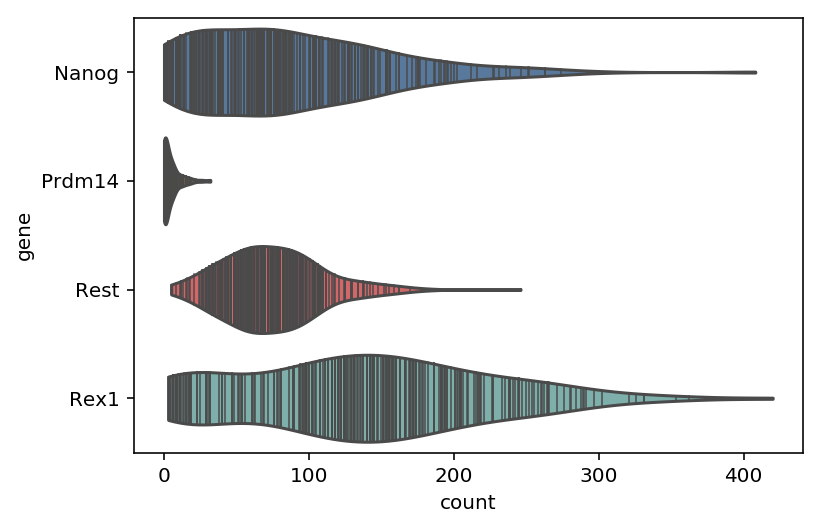

In [8]:
sns.violinplot(x='count',
               y='gene',
               data=df_tidy, 
               inner='stick',
               cut=0, 
               scale='width',
               order=sorted(list(df.columns)),
               palette=palette);

Putting all of the plots on the same scale obfuscates some of the original data points, but the ticks within the "violins" still gives a sense of the actual measured data.

The problem with violin plots is that, like choosing bins in a histogram, the choice of basis function for the kernel is an arbitrary choice (almost always Gaussian) and the bandwidth for the kernel density estimate is also arbitrary (Seaborn uses [Scott's method](https://doi.org/10.1093%2Fbiomet%2F66.3.605)).

So, how can we plot all of our data, still get the shape of a distribution, and not have any of the arbitrary choices we had with binning and bandwidth selection?

### Use ECDFs

The ECDF is a great option. The ECDF evaluated at _x_ for a set of measurements is defined as

>ECDF(*x*) = fraction of measurements ≤ _x_.

While the histogram is an attempt to visualize a probability density function (PDF) of a distribution, the ECDF visualizes the cumulative density function (CDF). Remember that the CDF, $F(x)$ and PDF, $f(x)$ both completely define a univariate distribution and are related by

\begin{align}
f(x) = \frac{\mathrm{d}F}{\mathrm{d}x}.
\end{align}

The definition of the ECDF is all that you need for interpretation. Once you get used to looking at CDFs, they will become as familiar as PDFs. A peak in a PDF corresponds to an inflection point in a CDF.

To make this more clear, let us look at plot of a PDF and ECDF for familiar distributions, the Gaussian and Binomial.

In [9]:
def xy_discrete_ecdf(fun_c, x_min, x_max, param_vals):
    # Set up data for plot
    x = np.arange(int(np.ceil(x_min)),
                  int(np.floor(x_max))+1)
    x_size = x[-1] - x[0]
    x_c = np.empty(2*len(x))
    x_c[::2] = x
    x_c[1::2] = x
    x_c = np.concatenate(((max(x[0] - 0.05*x_size, x[0] - 0.95),),
                          x_c,
                          (min(x[-1] + 0.05*x_size, x[-1] + 0.95),)))
    x_cdf = np.concatenate(((x_c[0],), x))

    # Compute PDF and CDF
    y_c = fun_c(x_cdf, *param_vals)
    y_c_plot = np.empty_like(x_c)
    y_c_plot[::2] = y_c
    y_c_plot[1::2] = y_c
    y_c = y_c_plot
    
    return x_c, y_c

# Set up plots
plots = [bokeh.plotting.figure(height=200, width=300, x_axis_label='x', title=title) 
             for title in ('Gaussian PDF', 'Gaussian CDF', 'Binomial PMF', 'Binomial CDF')]

# Gaussian
x = np.linspace(-3, 3, 200)
plots[0].line(x, st.norm.pdf(x, 0, 1), line_width=2)
plots[1].line(x, st.norm.cdf(x, 0, 1), line_width=2)

# Binomial
x = np.arange(21)
plots[2].circle(x, st.binom.pmf(x, 20, 0.5), size=5)
plots[2].segment(x0=x,
                 x1=x,
                 y0=0,
                 y1=st.binom.pmf(x, 20, 0.5),
                 line_width=2)
x, y = xy_discrete_ecdf(st.binom.cdf, 0, 20, (20, 0.5))
plots[3].line(x, y, line_width=2)

bokeh.io.show(bokeh.layouts.gridplot(plots, ncols=2))

Now that we have an understanding about CDFs, let's look at ECDFs of the smFISH data.

In [10]:
bokeh.io.show(bebi103.viz.ecdf_collection(df_tidy, 'gene', 'count'))

Now, we can clearly compare the distributions of the counts of all of the four genes. Importantly, we see that the Rex1 gene shows bimodality (two inflection points), and the Rest gene shows a mode near 65. Nanog and Prdm14 both fall off from a mode around zero. Furthermore, though Nanog has more counts with low copy number, it is more broadly distributed than Rest, having a heavier tail.

Now, given the above definition of the ECDF, it is defined for all real _x_. So, formally, the ECDF is a continuous function (with discontinuous derivatives at each data point). So, it should be plotted like a staircase according to the formal definition. (Nonetheless, the "dot" version of the ECDF contains the same information as when it is plotted as a staircase.)

In [11]:
bokeh.io.show(bebi103.viz.ecdf_collection(df_tidy, 'gene', 'count', formal=True, line_width=2))

While this is certainly a correct depiction of the ECDF, I prefer the dots version for data sets containing more than about 20 data points. I generally prefer this because it is easier to see the values of the measurements, which occur at the concave corners of the staircase representation. That said, when there are too few points, it is harder to make out the shape of the ECDF, so in those cases, I prefer the staircase.

### You can add bootstrap confidence intervals to the ECDF

The ECDF also affords us to display bootstrap confidence intervals around the ECDF, as shown, for example, with the Rest gene.

In [12]:
p = bebi103.viz.ecdf(df['Rest'], conf_int=True, line_width=2)
bokeh.io.show(p)

## Displaying results from parameter estimation

Gene expression is bursty, which leads to mRNA counts being Negative-Binomially distributed for a given gene. The Negative Binomial distribution has two parameters, the burst size $b$ and the burst frequency $\alpha$. We can perform a maximum likelihood estimate to get the parameters for a Negative Binomial distribution fitting the observed data, say for the Rest gene.

In [13]:
def neg_likelihood(params, n):
    alpha, b = params
    beta = 1 / b
    return -st.nbinom.logpmf(n, alpha, beta/(1+beta)).sum()

def mle(data):
    res = scipy.optimize.minimize(neg_likelihood, [1, 1], args=(data,))
    return res.x[0], res.x[1]

alpha, b = mle(df['Rest'].values)

print("""Maximum-likelihood estimate:
burst freq, α = {0:.2f}
burst size, b = {1:.2f}
""".format(alpha, b))

Maximum-likelihood estimate:
burst freq, α = 4.53
burst size, b = 16.54



### Do not show the "best fit line"

We can generate a CDF for the MLE parameters and overlay that with the ECDF.

In [14]:
x, y = xy_discrete_ecdf(st.nbinom.cdf, 0, 250, (alpha, 1/(1+b)))
p.line(x, y, color='orange', line_width=2)

bokeh.io.show(p)

We should not do this because there is something much better! 

### Better, show what data could be generated

When doing parametric statistical inference, I prefer to take a generative Bayesian approach. We posit a generative model from which the data are drawn. The "drawing" is performed by doing an experiment. Below is a generative model for counts of mRNA comig from bursty gene expression.

\begin{align}
&\alpha \sim \text{LogNorm}(0,2), \\[1em]
&b \sim \text{LogNorm}(2, 3), \\[1em]
&\beta = 1/b,\\[1em]
&n_i \sim \text{NegBinom}(\alpha, \beta) \;\forall i.
\end{align}

We will perform Markov chain Monte Carlo (MCMC) to get the posterior distributions for $\alpha$ and $b$. This gives us our parameter estimates. We can then generate the data sets we would expect from our newly understood model. We draw values of $\alpha$ and $b$ out of the posterior distribution (which are really just our MCMC samples), and then draw data out of the likelihood conditioned on these parameters $\alpha$ and $b$.

First, we use Stan to get the samples, first for the *rest* gene.

In [15]:
model_code = """
data {
  int N;
  int n[N];
}


parameters {
  real<lower=0> alpha;
  real<lower=0> b;
}


transformed parameters {
  real beta_ = 1.0 / b;
}


model {
  // Priors
  alpha ~ lognormal(0.0, 2.0);
  b ~ lognormal(2.0, 3.0);

  // Likelihood
  n ~ neg_binomial(alpha, beta_);
}


generated quantities {
  int n_ppc[N];

  // Draw posterior predictive data set
  for (i in 1:N) {
    n_ppc[i] = neg_binomial_rng(alpha, beta_);
  }
}
"""

sm = bebi103.stan.StanModel(model_code=model_code)

data = dict(N=len(df),
            n=df['Rest'].values.astype(int))

samples = sm.sampling(data=data)

Using cached StanModel.


Now, we can plot the ECDF of the data, along with percentiles of the predictive data from the posterior.

In [16]:
p = bebi103.viz.predictive_ecdf(samples, name='n_ppc', x_axis_label='x', 
                                data=df['Rest'], title='Rest')
bokeh.io.show(p)

In this plot, the middle dark blue line is the median, and then the shades of blue expand to encompass the middle 20th, 40th, 60th, and 80th percentiles of posterior predictive ECDFs. This is hard to see in the above plot without zooming. A better use of space would be to plot the *difference* of the ECDF compared to the median of the posterior predictive ECDFs. I usually like to show these plots side-by-side.

In [17]:
p2 = bebi103.viz.predictive_ecdf(samples, name='n_ppc', x_axis_label='x', data_line=False, 
                                 data=df['Rest'], diff=True)
bokeh.io.show(bokeh.layouts.gridplot([p, p2], ncols=2))

Based on this plot, the posterior predictive distribution seems to encompass what was actually measured. There are a few points outside the 80th percentile of the posterior predictive samples, but that is expected. We conclude that at least that the observed data are captured with the model.

### Plotting predictive data exposes model failures

As is clear by inspection, the data for Rex1 is not Negative-Binomially distributed, as it is bimodal. The posterior predictive plots show this.

In [18]:
data = dict(N=len(df),
            n=df['Rex1'].values.astype(int))

samples = sm.sampling(data=data)

p = bebi103.viz.predictive_ecdf(samples, name='n_ppc', x_axis_label='x', 
                                data=df['Rex1'], title='Rex1')
p2 = bebi103.viz.predictive_ecdf(samples, name='n_ppc', x_axis_label='x', data_line=False, 
                                 data=df['Rex1'], diff=True)
bokeh.io.show(bokeh.layouts.gridplot([p, p2], ncols=2))

### We should also plot predictive data for regressions

When we do regressions, which typically involves finding the "best fit" line for $x$-$y$ data, we often plot the best fit line. We should also avoid doing this, instead plotting results from predictive data.

[Matt Good and coworkers](https://doi.org/10.1126/science.1243147) studied the size of mitotic spindles in reconstituted droplets as a function of droplet size. Theoretically, the length $l$ of the microtubule depends on the droplet diameter $d$ as

\begin{align}
l(d) = \frac{\gamma d}{\left(1+(\gamma d/\phi)^3\right)^{\frac{1}{3}}}.
\end{align}

A plot of the data reveals the nonlinearity.

In [19]:
# Load in Data Frame
df = pd.read_csv('good_invitro_droplet_data.csv', comment='#')

# Make a plot
p = bokeh.plotting.figure(width=500, height=300, 
                          x_axis_label='droplet diameter (µm)', 
                          y_axis_label='spindle length (µm)')
p.circle(df['Droplet Diameter (um)'], df['Spindle Length (um)'], alpha=0.3)

bokeh.io.show(p)

A generative model for the $\{d, l\}$ data set is then

\begin{align}
&\phi \sim \text{LogNorm}(\ln 20, 0.75),\\[1em]
&\gamma \sim \text{Beta}(2, 2), \\[1em]
&\sigma_0 \sim \text{Gamma}(2, 10),\\[1em]
&\sigma = \sigma_0\,\phi,\\[1em]
&\mu_i =  \frac{\gamma d_i}{\left(1+(\gamma d_i/\phi)^3\right)^{\frac{1}{3}}}, \\[1em]
&l_i \sim \text{Norm}(\mu_i, \sigma) \;\forall i.
\end{align}

We can again use Stan to sample from the posterior and generate the posterior predictive data.

In [20]:
model_code = """
functions {
  real ell_theor(real d, real phi, real gamma) {
    real denom_ratio = (gamma * d / phi)^3;
    return gamma * d / (1 + denom_ratio)^(1.0 / 3.0); 
  }
}


data {
  int N;
  real d[N];
  real ell[N];
}


parameters {
  real phi;
  real gamma;
  real sigma_0;
}


transformed parameters {
  real sigma = sigma_0 * phi;
}


model {
  phi ~ lognormal(log(20.0), 0.75);
  gamma ~ beta(2.0, 2.0);
  sigma_0 ~ gamma(2.0, 10.0);
  
  for (i in 1:N) {
    ell[i] ~ normal(ell_theor(d[i], phi, gamma), sigma);
  }
}


generated quantities {
  real ell_ppc[N];
  real log_lik[N];
  
  // Posterior predictive checks
  for (i in 1:N) {
    ell_ppc[i] = normal_rng(ell_theor(d[i], phi, gamma), sigma);
  }
  
  // Pointwise log likelihood
  for (i in 1:N) {
    log_lik[i] = normal_lpdf(ell[i] | ell_theor(d[i], phi, gamma), sigma);
  }
}
"""

# Compile Stan model
sm = bebi103.stan.StanModel(model_code=model_code)

# Set up data dict
data = dict(N=len(df),
            d=df['Droplet Diameter (um)'].values,
            ell=df['Spindle Length (um)'].values)

# Draw samples
samples = sm.sampling(data=data)

# Show the plot
bokeh.io.show(bebi103.viz.predictive_regression(
        samples, 
        x_axis_label='droplet diameter (µm)',
        y_axis_label='spindle length (µm)',
        name='ell_ppc', 
        data_x=df['Droplet Diameter (um)'].values,
        data_y=df['Spindle Length (um)'].values,
        data_alpha=0.5,
        diff=False))

Using cached StanModel.


It looks like about 20% of the 670 data points lie outside the middle 80th percentile of the predictive data, which is expected, so the model predicts the data reasonably well.

## Computing environment

In [21]:
%load_ext watermark
%watermark -v -p numpy,pandas,pystan,bokeh,seaborn,bebi103,jupyterlab

CPython 3.7.3
IPython 7.1.1

numpy 1.16.2
pandas 0.24.2
pystan 2.18.0.0
bokeh 1.1.0
seaborn 0.9.0
bebi103 0.0.41
jupyterlab 0.35.4
